Trial 70 Complete [00h 00m 18s]
val_accuracy: 0.6202020049095154

Best val_accuracy So Far: 0.9131312966346741
Total elapsed time: 00h 21m 52s

Best Hyperparameters:
LSTM Units: 96
Dropout Rate: 0.2
Dense Units: 96
Learning Rate: 0.01
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.4415 - loss: 1.4085 - val_accuracy: 0.3556 - val_loss: 2.1301
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5954 - loss: 1.0045 - val_accuracy: 0.2222 - val_loss: 2.4688
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6388 - loss: 0.9132 - val_accuracy: 0.2283 - val_loss: 2.4909
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7395 - loss: 0.7276 - val_accuracy: 0.2626 - val_loss: 1.6980
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7220 - loss: 0.7002 - val_accuracy: 0.3172 - val_loss: 1.7490
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7801 - loss: 0.5559 - val_accuracy: 0.4909 - val_loss: 1.2

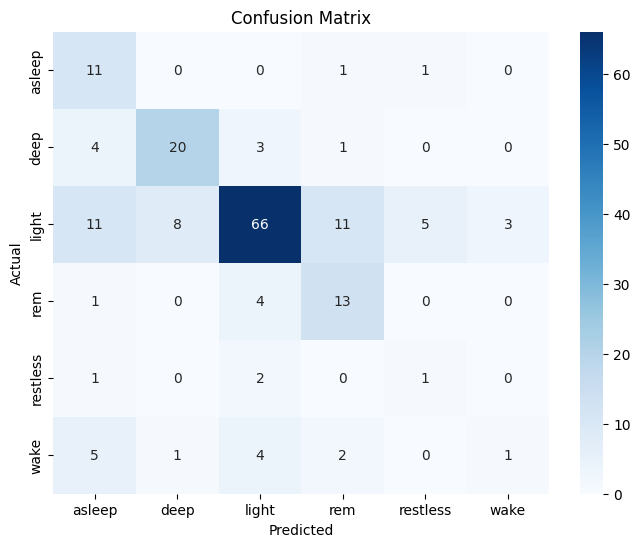


Mean Squared Error (MSE): 2.0444
Mean Absolute Error (MAE): 0.7556
Mean Absolute Scaled Error (MASE): 2.2964

Model saved as 'best_lstm_sleep_level_model.h5'.
Scaler saved as 'scaler.joblib'.
Label Encoder saved as 'label_encoder.joblib'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step

Predicted Sleep Level: light


In [1]:
# ====================================
# Step 0: Import Necessary Libraries
# ====================================
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Added for MSE and MAE

from imblearn.over_sampling import SMOTE  # For handling imbalanced data

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

import keras_tuner as kt  # For hyperparameter tuning

import matplotlib.pyplot as plt
import seaborn as sns

import joblib  # For saving the trained model

# ====================================
# Step 1: Load and Preprocess the Data
# ====================================

# -----------------------------
# 1.1: Load Your Data
# -----------------------------
data = pd.read_csv('E:\chatbot-01\datasets\sleep_data\sleep_hr\spo2_heart_sleep_data.csv') 
df = pd.DataFrame(data)

# -----------------------------
# 1.2: Handle Missing Values
# -----------------------------
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Fill missing values with column mean (if any)
df['bpm'].fillna(df['bpm'].mean(), inplace=True)
df['spo2_value'].fillna(df['spo2_value'].mean(), inplace=True)

# -----------------------------
# 1.3: Remove Outliers Using IQR
# -----------------------------
columns_to_check = ['bpm', 'spo2_value']
Q1 = df[columns_to_check].quantile(0.25)
Q3 = df[columns_to_check].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a boolean mask for non-outliers
mask = ~((df[columns_to_check] < lower_bound) | (df[columns_to_check] > upper_bound)).any(axis=1)

initial_count = df.shape[0]
df_cleaned = df[mask].copy()
final_count = df_cleaned.shape[0]
outliers_removed = initial_count - final_count

print(f"\nNumber of outliers detected and removed: {outliers_removed}")

df = df_cleaned

# -----------------------------
# 1.4: Feature Engineering - Process 'dateTime'
# -----------------------------
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%m/%d/%Y %H:%M')
df['hour'] = df['dateTime'].dt.hour
df['minute'] = df['dateTime'].dt.minute
df['second'] = df['dateTime'].dt.second
df['day'] = df['dateTime'].dt.day
df['month'] = df['dateTime'].dt.month
df.drop('dateTime', axis=1, inplace=True)

# -----------------------------
# 1.5: Label Encoding the Target Variable
# -----------------------------
le = LabelEncoder()
df['level_encoded'] = le.fit_transform(df['level'])
print("\nLabel Mapping:")
print(dict(zip(le.classes_, le.transform(le.classes_))))

# ----------------------------------------
# 1.6: Check the Distribution of Classes
# ----------------------------------------
print("\nClass Distribution in Entire Dataset:")
print(df['level'].value_counts())

# -----------------------------
# 1.7: Feature Selection and Scaling
# -----------------------------
feature_cols = ['hour', 'minute', 'bpm', 'spo2_value']
X = df[feature_cols].values
y = df['level_encoded'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 1.8: Create Sequences for LSTM
# -----------------------------
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 3  # Adjust based on your data and requirements
X_seq, y_seq = create_sequences(X_scaled, y, sequence_length)

print(f"\nShape of X sequences: {X_seq.shape}")
print(f"Shape of y labels: {y_seq.shape}")

# ====================================
# Step 2: Train-Test Split with Stratification
# ====================================
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"\nTraining sequences shape: {X_train.shape}")
print(f"Testing sequences shape: {X_test.shape}")

# ----------------------------------------
# Check the Distribution of Classes
# ----------------------------------------
print("\nClass Distribution in Training Set:")
print(pd.Series(y_train).value_counts())

print("\nClass Distribution in Test Set:")
print(pd.Series(y_test).value_counts())

# ====================================
# Step 3: Handle Class Imbalance with SMOTE
# ====================================

# -----------------------------
# 3.1: Apply SMOTE to Training Data
# -----------------------------
# Flatten the sequences for SMOTE
X_train_flat = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

smote = SMOTE(random_state=42)
X_train_res_flat, y_train_res = smote.fit_resample(X_train_flat, y_train)

print("\nAfter SMOTE, the training set has the following class distribution:")
print(pd.Series(y_train_res).value_counts())

# Reshape the data back to sequences
X_train_res = X_train_res_flat.reshape((X_train_res_flat.shape[0], sequence_length, X_train.shape[2]))

print(f"\nReshaped training sequences shape: {X_train_res.shape}")

# ====================================
# Step 4: Convert Labels to Categorical
# ====================================
num_classes = len(np.unique(y_train_res))
y_train_cat = to_categorical(y_train_res, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# ====================================
# Step 5: Build and Tune the LSTM Model
# ====================================

# -----------------------------
# 5.1: Define the Hypermodel
# -----------------------------
def build_model(hp):
    model = Sequential()
    
    # Hyperparameter tuning for number of LSTM units
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=256, step=32)
    
    model.add(LSTM(units=lstm_units, input_shape=(X_train_res.shape[1], X_train_res.shape[2]), return_sequences=True))
    
    # Hyperparameter tuning for dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=dropout_rate))
    
    # Additional LSTM layer
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(rate=dropout_rate))
    
    # Hyperparameter tuning for number of Dense units
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(Dense(units=dense_units, activation='relu'))
    
    # Output layer
    model.add(Dense(units=num_classes, activation='softmax'))
    
    # Hyperparameter tuning for learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# -----------------------------
# 5.2: Initialize the Tuner
# -----------------------------
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=70,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='sleep_level_classification'
)

# -----------------------------
# 5.3: Early Stopping Callback
# -----------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# -----------------------------
# 5.4: Run the Hyperparameter Search
# -----------------------------
tuner.search(
    X_train_res, y_train_cat,
    epochs=200,
    validation_split=0.2,
    callbacks=[early_stop],
    batch_size=32
)

# -----------------------------
# 5.5: Retrieve the Best Model
# -----------------------------
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_res, y_train_cat,
    epochs=200,
    validation_split=0.2,
    callbacks=[early_stop],
    batch_size=32
)

# ====================================
# Step 6: Evaluate the Model with Additional Metrics
# ====================================

# -----------------------------
# 6.1: Predictions on Test Data
# -----------------------------
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test

# -----------------------------
# 6.2: Accuracy
# -----------------------------
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")

# -----------------------------
# 6.3: Classification Report
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# -----------------------------
# 6.4: Confusion Matrix
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# -----------------------------
# 6.5: Mean Squared Error (MSE)
# -----------------------------
mse = mean_squared_error(y_true, y_pred)
print(f"\nMean Squared Error (MSE): {mse:.4f}")

# -----------------------------
# 6.6: Mean Absolute Error (MAE)
# -----------------------------
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# -----------------------------
# 6.7: Mean Absolute Scaled Error (MASE)
# -----------------------------
def calculate_mase(y_true, y_pred, y_train):
    n = len(y_true)
    d = np.abs(np.diff(y_train)).sum() / (len(y_train) - 1)
    errors = np.abs(y_true - y_pred)
    mase = errors.mean() / d
    return mase

# Flatten y_train_res to use in MASE calculation
y_train_flat = y_train_res

mase = calculate_mase(y_true, y_pred, y_train_flat)
print(f"Mean Absolute Scaled Error (MASE): {mase:.4f}")

# ====================================
# Step 7: Save the Trained Model and Scaler
# ====================================

# -----------------------------
# 7.1: Save the Best Model
# -----------------------------
model_filename = 'best_lstm_sleep_level_model.h5'
best_model.save(model_filename)
print(f"\nModel saved as '{model_filename}'.")

# -----------------------------
# 7.2: Save the Scaler and Label Encoder
# -----------------------------
joblib.dump(scaler, 'scaler.joblib')
print("Scaler saved as 'scaler.joblib'.")

joblib.dump(le, 'label_encoder.joblib')
print("Label Encoder saved as 'label_encoder.joblib'.")

# ====================================
# Step 8: (Optional) Load and Use the Saved Model for Predictions
# ====================================

# -----------------------------
# 8.1: Load the Model, Scaler, and Label Encoder
# -----------------------------
# Load the model
loaded_model = tf.keras.models.load_model('best_lstm_sleep_level_model.h5')

# Load the scaler and label encoder
scaler = joblib.load('scaler.joblib')
le = joblib.load('label_encoder.joblib')

# -----------------------------
# 8.2: Prepare New Data for Prediction
# -----------------------------
# Example new data (replace with actual new data)
new_data = pd.DataFrame({
    'hour': [2],
    'minute': [5],
    'bpm': [100],
    'spo2_value': [96.0]
})

# Feature scaling
new_X = scaler.transform(new_data)

# Create a sequence (for simplicity, replicate the new data to match sequence_length)
new_sequence = np.tile(new_X, (sequence_length, 1)).reshape(1, sequence_length, new_X.shape[1])

# Predict
prediction_prob = loaded_model.predict(new_sequence)
prediction = np.argmax(prediction_prob, axis=1)
sleep_level = le.inverse_transform(prediction)[0]

print(f"\nPredicted Sleep Level: {sleep_level}")
